In [1]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

# importing torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

# setting dtype and seeds for repoducibility
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.manual_seed(1)
np.random.seed(1)

In [2]:
# constants
reduced_h = 1.0
mass = 1.0

# potential well parameters
end_l = -0.5 
end_r = 0.5
l = end_r - end_l
V_well = 0.0    
V_barrier = 40.0 

# boundary conditions
f_b = 0.0
x_l = -6.0
x_r = 6.0

# potential function
def potential(x):
    return torch.where((x >= end_l) & (x <= end_r), torch.tensor(V_well), torch.tensor(V_barrier))

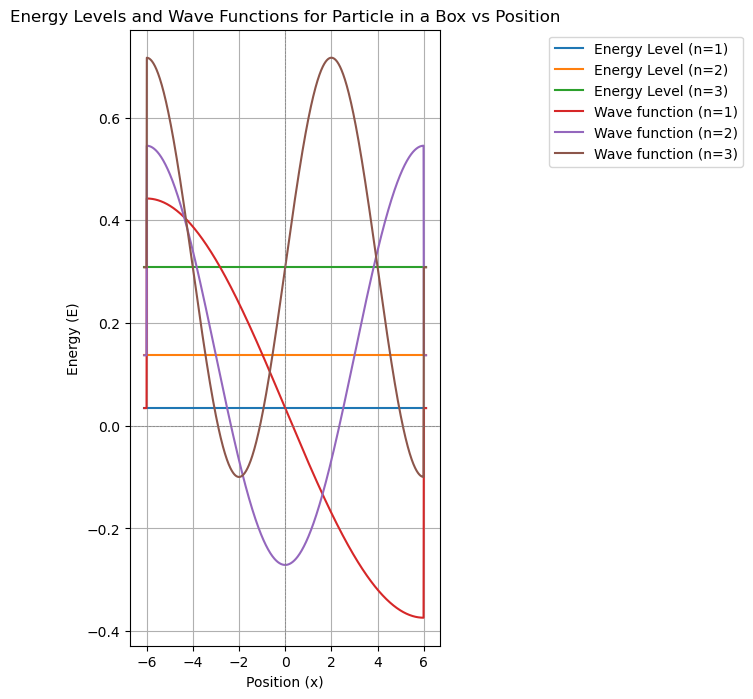

In [3]:

# Exact solution (even wavefunctions)
def wavefn(n, x):
    condition = (x >= x_l) & (x <= x_r)
    result = torch.zeros_like(x)
    norm_const = torch.sqrt(2 / torch.tensor(x_r - x_l))
    kn = n * np.pi / (x_r - x_l)
    result[condition] = norm_const * torch.cos(kn * (x[condition] - x_l))
    return result

def energy(n):
    kn = n * np.pi / (x_r - x_l)
    return (reduced_h ** 2 * kn ** 2) / (2 * mass)

# plotting the exact solutions
x_values = torch.linspace(x_l - 0.1, x_r + 0.1, 1000)
num_max = 3 

energy_levels = np.array([[energy(n) for _ in x_values] for n in range(1, num_max+1)])
wave_functions = np.array([[wavefn(n, x).detach().numpy() for x in x_values] for n in range(1, num_max+1)])

plt.figure(figsize=(4, 8))

for n in range(num_max):
    plt.plot(x_values, energy_levels[n], label=f'Energy Level (n={n+1})')

for n in range(num_max):
    plt.plot(x_values, energy_levels[n] + wave_functions[n], label=f'Wave function (n={n+1})')

plt.xlabel('Position (x)')
plt.ylabel('Energy (E)')
plt.title('Energy Levels and Wave Functions for Particle in a Box vs Position')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Horizontal line at y=0
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')  # Vertical line at x=0

plt.legend(loc='upper right', bbox_to_anchor=(2, 1))
plt.grid(True)
plt.show()

In [4]:
# custom activation function
class sinfn(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)
    
# autograd differentiation function
def dfx(x,f):
    return grad(f, x, grad_outputs=torch.ones(x.shape), create_graph=True)[0]

# parameterized solution
def solution(x, model):
    phi, _ = model(x)
    g = (1-torch.exp(c*(x_l - x)))*(1-torch.exp(c*(x - x_r)))
    psi = f_b + g * phi
    return psi

# gaussian perturbation to inputs
def perturb(sample, x_l, x_r, sigma=0.5):
    sample_range = sample.max() - sample.min()
    scale_factor = (x_r - x_l) / sample_range
    scaled_sample = (sample - sample.min()) * scale_factor + x_l
    noise = torch.randn_like(sample) * sigma
    x = scaled_sample + noise
    x.clamp_(x_l, x_r)
    x[0] = x_l
    x[-1] = x_r
    x.requires_grad = False  
    return x


In [5]:
# neural network model
class EigenNN(nn.Module):
    def __init__(self, num_neurons=50):
        super(EigenNN, self).__init__()
        self.activation = sinfn()
        self.eigen  = nn.Linear(1,1)
        self.linear1  = nn.Linear(2, num_neurons)
        self.linear2  = nn.Linear(num_neurons, num_neurons)
        self.out    = nn.Linear(num_neurons, 1)

    def forward(self, x):
        value = self.eigen(torch.ones_like(x))
        psi = self.linear1(torch.cat((x, value), 1))
        psi = self.activation(psi)
        psi = self.linear2(psi)
        psi = self.activation(psi)
        psi = self.out(psi)
        return psi, value

In [6]:
# model specifications
num_neurons = 50
model = EigenNN(num_neurons)
best_model = 0 

# optimizer specifications
lr = 8e-3
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

# regularization constants
vf = 1
vl = 1
vd = 1

# hyperparameter
c = 1
limits = 1e+20
walle = -4

# loss histories
loss_history = []
Lde_history = []
Ld_history = []
Lf_history = []
Ll_history = []

# eigenvalue history
En_history = []
wall_history = []

E_limits = (None, 1e+20)
models = {0:E_limits, 1:E_limits, 2:E_limits, 3:E_limits, 4:E_limits, 5:E_limits, 6:E_limits, 7:E_limits, 8:E_limits, 9:E_limits, 10:E_limits}

# inputs
num_train = 1200
sample = torch.linspace(x_l, x_r, num_train).reshape(-1,1)

num_epochs = int(85e+3)

for epoch in tqdm(range(num_epochs)): 
    data_train = perturb(sample, x_l, x_r, sigma = .03*x_r)
    data_train = data_train[np.random.permutation(num_train)]
    data_train.requires_grad = True
        
    _, En = model(data_train)
    En_history.append(En[0].data.tolist()[0])

    psi  = solution(data_train, model)
    V0 = potential(data_train)

    psix = dfx(data_train, psi)
    psixx = dfx(data_train, psix)
    Lde = ((reduced_h**2/(2*mass)) * psixx + (En-V0)*psi).pow(2).mean()
    Lde_history.append(Lde.detach().numpy())
            
    if epoch%2600 == 0:
        walle += 1

    Lf = 1/((psi.pow(2)).mean()+1e-6)
    Ll = 1/(En.pow(2).mean()+1e-6)
    Ld = torch.exp(-1*En + walle).mean()
            
    loss = Lde + vf*Lf + vl*Ll + vd*Ld

    Ld_history.append(Ld.detach().numpy())
    Ll_history.append(Ll.detach().numpy())
    Lf_history.append(Lf.detach().numpy())
    wall_history.append(walle)

    loss.backward(retain_graph=False)
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.data.numpy())

    if  Lde < limits:
        best_model =  copy.deepcopy(model)
        limits = Lde

    bin = abs(En[0].data.tolist()[0]//10) 
    if Lde < models[bin][1]:
          models[bin] = (copy.deepcopy(model), Lde)

loss_history = np.array(loss_history)
Lde_history = np.array(Lde_history)
Lf_history = np.array(Lf_history)
Ll_history = np.array(Ll_history)
Ld_history = np.array(Ld_history)

En_history = np.array(En_history)
wall_history = np.array(wall_history)
loss_histories = [loss_history, Lde_history, Lf_history, Ll_history, Ld_history, En_history, wall_history]
model = best_model

100%|██████████| 85000/85000 [12:46<00:00, 110.92it/s]


In [12]:
wall_history

array([-3, -3, -3, ..., 29, 29, 29])

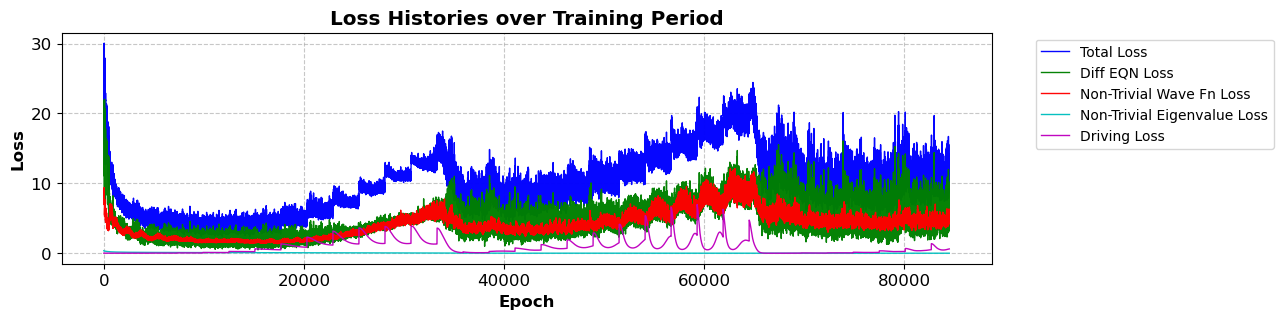

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))
num = 500
ax.plot(loss_history[num:], '-b', linewidth=1, alpha=0.975, label='Total Loss') 
ax.plot(Lde_history[num:], '-g', linewidth=1, alpha=0.975, label='Diff EQN Loss') 
ax.plot(Lf_history[num:], '-r', linewidth=1, alpha=0.975, label='Non-Trivial Wave Fn Loss') 
ax.plot(Ll_history[num:], '-c', linewidth=1, alpha=0.975, label='Non-Trivial Eigenvalue Loss')
ax.plot(Ld_history[num:], '-m', linewidth=1, alpha=0.975, label='Driving Loss')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch', fontsize='large', fontweight='bold')
ax.set_ylabel('Loss', fontsize='large', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize='large')
ax.set_title('Loss Histories over Training Period', fontsize='x-large', fontweight='bold')
plt.show()

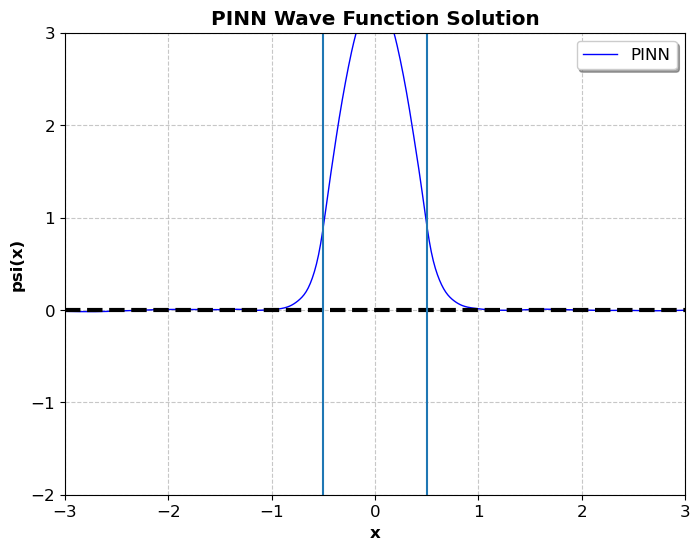

In [16]:
# extracting results
num_test = num_train 
data_test = torch.linspace(x_l, x_r, num_test)
data_test = data_test.reshape(-1, 1)
data_test.requires_grad = True
data_net = data_test.detach().numpy()
psi = solution(data_test, model) 
psi = psi.data.numpy()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data_net, psi, '-b', linewidth=1, label='PINN') 
ax.legend() 
ax.axhline(y=0, color='k', linestyle='--', linewidth=3) 
ax.set_xlim(-3, 3)
ax.set_ylim(-2, 3)
ax.axvline(x = -0.5)
ax.axvline(x = 0.5)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize='large', shadow=True)
ax.set_xlabel('x', fontsize='large', fontweight='bold')
ax.set_ylabel('psi(x)', fontsize='large', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize='large')
ax.set_title('PINN Wave Function Solution', fontsize='x-large', fontweight='bold')
plt.show()


In [10]:
models

{0: (EigenNN(
    (activation): sinfn()
    (eigen): Linear(in_features=1, out_features=1, bias=True)
    (linear1): Linear(in_features=2, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=50, bias=True)
    (out): Linear(in_features=50, out_features=1, bias=True)
  ),
  tensor(0.4725, grad_fn=<MeanBackward0>)),
 1: (EigenNN(
    (activation): sinfn()
    (eigen): Linear(in_features=1, out_features=1, bias=True)
    (linear1): Linear(in_features=2, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=50, bias=True)
    (out): Linear(in_features=50, out_features=1, bias=True)
  ),
  tensor(0.9877, grad_fn=<MeanBackward0>)),
 2: (EigenNN(
    (activation): sinfn()
    (eigen): Linear(in_features=1, out_features=1, bias=True)
    (linear1): Linear(in_features=2, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=50, bias=True)
    (out): Linear(in_features=50, out_features=1, bias=True)
  ),
  tensor(1.2697

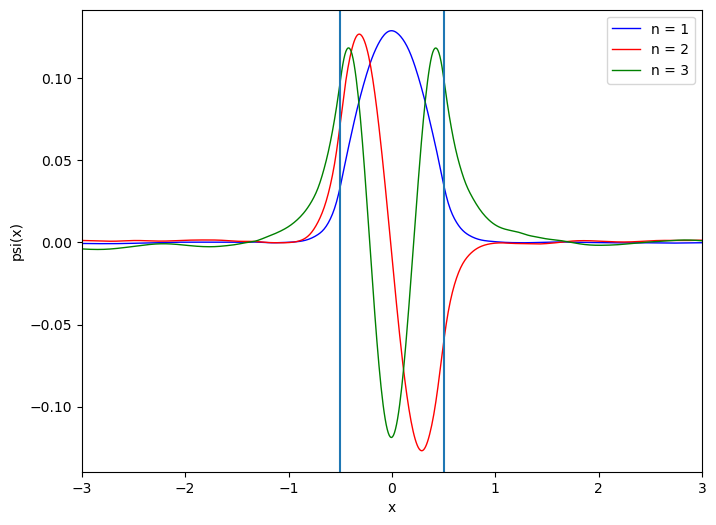

In [18]:
plt.figure(figsize = (8,6))

# getting neural network solutions
psi_n1 = solution(data_test, models[0][0])
psi_n2 = solution(data_test, models[1][0])
psi_n3 = solution(data_test, models[2][0])

# scaling the solutions
psi_n1 = psi_n1.data.numpy()
psi_n2 = psi_n2.data.numpy()
psi_n3 = psi_n3.data.numpy()

psi_n1 = psi_n1/np.linalg.norm(psi_n1)
psi_n2 = psi_n2/np.linalg.norm(psi_n2)
psi_n3 = psi_n3/np.linalg.norm(psi_n3)

# plotting the solutions
plt.plot(data_net, psi_n1, '-b', linewidth=1, label = 'n = 1')
plt.plot(data_net, psi_n2, '-r', linewidth=1, label = 'n = 2')
plt.plot(data_net, psi_n3, '-g', linewidth=1, label = 'n = 3')
plt.xlim(-3, 3)

plt.axvline(x = -0.5)
plt.axvline(x = 0.5)
plt.ylabel('psi(x)') 
plt.xlabel('x')
plt.legend()
plt.show()

In [19]:
print("Predicted Energy of Infinite Pot Well for n=1 :", models[0][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :")
print("Predicted Energy of Infinite Pot Well for n=2 :", models[1][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :")
print("Predicted Energy of Infinite Pot Well for n=3 :", models[2][0].forward(data_test)[1][0].data.numpy(), "Exact Energy :")

Predicted Energy of Infinite Pot Well for n=1 : [3.4930282] Exact Energy :
Predicted Energy of Infinite Pot Well for n=2 : [13.503796] Exact Energy :
Predicted Energy of Infinite Pot Well for n=3 : [28.25677] Exact Energy :


In [33]:
B = 1
A = 0.28624/0.013774
tru2 = B*np.cos(2.561*data_test.data.numpy()[550:650])
tru1 = A*np.exp(8.57*data_test.data.numpy()[:550])
tru3 = A*np.exp(-8.57*data_test.data.numpy()[650:])
tru = np.concatenate((tru1, tru2, tru3), axis = 0)


Mean Squared Error: [2.672127e-07]


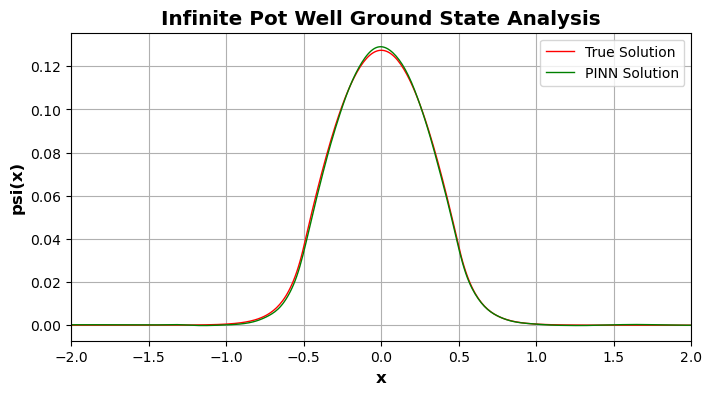

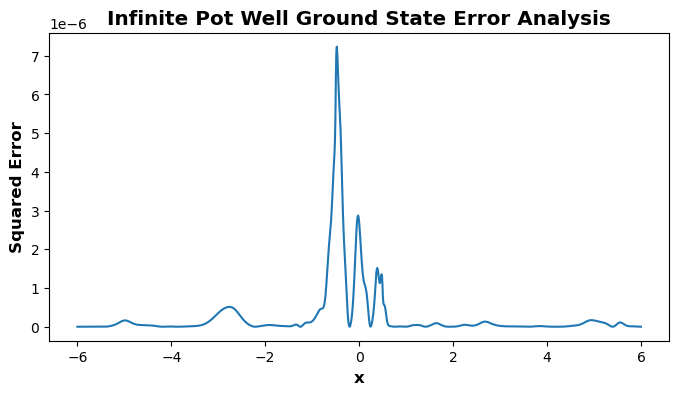

In [35]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[0][0])
psi = psi.data.numpy() 

# normalization
psi = psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-2,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))


In [48]:
k = 5.076; alpha = 7.364

B = 1
A = B*-0.5676/0.025173
truII = B*np.sin(k*data_test.data.numpy()[550:650])
truI = A*np.exp(alpha*data_test.data.numpy()[:550])
truIII = -A*np.exp(-alpha*data_test.data.numpy()[650:])

tru = np.concatenate((truI, truII, truIII), axis = 0)

Mean Squared Error: [4.935728e-06]


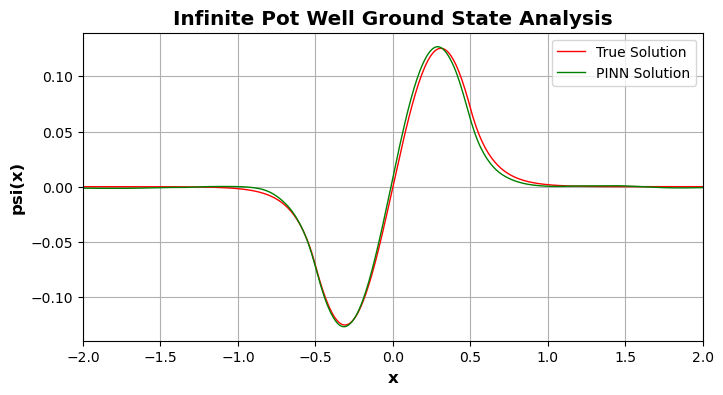

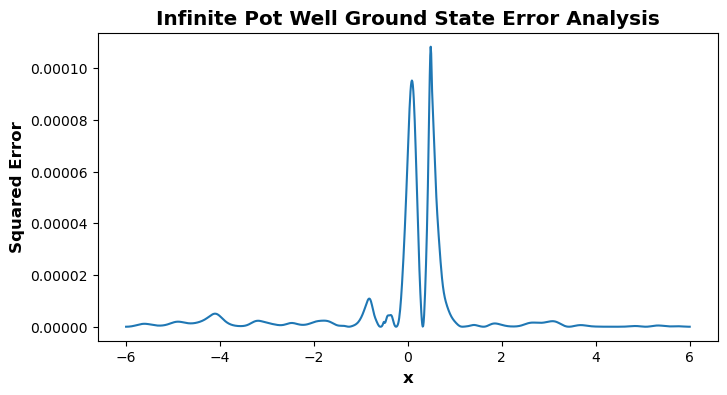

In [49]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[1][0])
psi = psi.data.numpy() 

# normalization
psi = (-1)*psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-2,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))

In [39]:
# for E = 27.783, 
k = 7.4543; alpha = 4.9431
B = 1
A = B*-0.8334/0.084454
truII = B*np.cos(k*data_test.data.numpy()[550:650])
truI = A*np.exp(alpha*data_test.data.numpy()[:550])
truIII = A*np.exp(-alpha*data_test.data.numpy()[650:])

tru = np.concatenate((truI, truII, truIII), axis = 0)

Mean Squared Error: [4.7544904e-06]


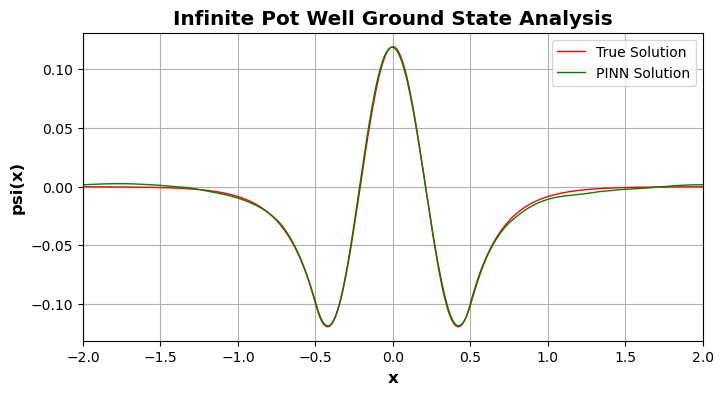

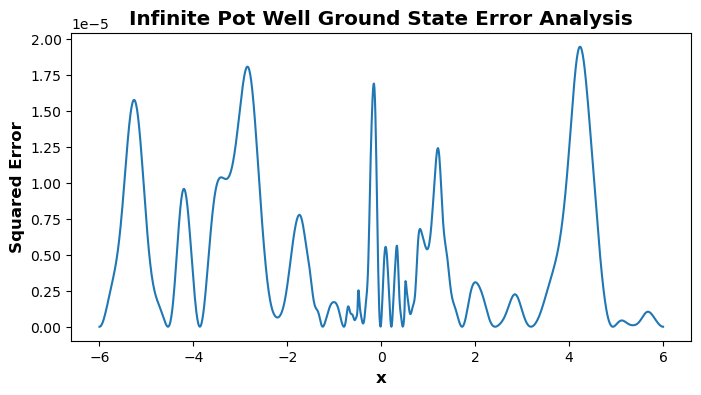

In [42]:
figsize = (8,4)
plt.figure(figsize = figsize)

psi = solution(data_test, models[2][0])
psi = psi.data.numpy() 

# normalization
psi = (-1)*psi/np.linalg.norm(psi)
tru = tru/np.linalg.norm(tru)

plt.plot(data_net, tru, '-r', linewidth=1, label = 'True Solution')
plt.plot(data_net, psi, '-g', linewidth=1, label = 'PINN Solution')
plt.xlim(-2,2)
plt.legend()
plt.xlabel('x', fontsize='large', fontweight='bold')
plt.ylabel('psi(x)', fontsize='large', fontweight='bold')
plt.grid('on')
plt.title('Infinite Pot Well Ground State Analysis', fontsize='x-large', fontweight='bold')

plt.figure(figsize = figsize)
plt.plot(data_net, (tru-psi)**2)
plt.title('Infinite Pot Well Ground State Error Analysis', fontsize='x-large', fontweight='bold')
plt.ylabel('Squared Error', fontsize='large', fontweight='bold')
plt.xlabel('x', fontsize='large', fontweight='bold')
print('Mean Squared Error: ' + str(sum((tru-psi)**2)/len(tru)))